In [ ]:
!pip install pandas matplotlib scikit-learn tensorflow joblib --quiet


important imports (libraries)

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import data

In [7]:
# Load data
df = pd.read_csv("starlink.csv")

Normalization

In [8]:
# Selected features
features = ['Altitude_km', 'Eccentricity', 'Inclination_deg', 'Mean_Motion_orbits_per_day']

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

Sequential training

In [9]:
# Create sequences
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_len=10)

Model building

In [10]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(len(features))  # output layer
])

# Compile
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training

In [11]:
# Train
history = model.fit(
    X, y,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0329 - mae: 0.1054 - val_loss: 0.0127 - val_mae: 0.0546 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0090 - mae: 0.0546 - val_loss: 0.0124 - val_mae: 0.0507 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0088 - mae: 0.0529 - val_loss: 0.0128 - val_mae: 0.0616 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0080 - mae: 0.0502 - val_loss: 0.0123 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0082 - mae: 0.0514 - val_loss: 0.0122 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0084 - mae: 0.0508 - val_loss: 0.0125 - val_mae: 0.0580 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0086 - mae: 0.0517 - val_loss: 0.0121 - val_mae: 0.0515 - learning_rate: 0.0010

Testing

In [12]:
# Predict last sample
predicted = model.predict(X[-1].reshape(1, X.shape[1], X.shape[2]))
pred = scaler.inverse_transform(predicted)[0]
actual = scaler.inverse_transform([y[-1]])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Visualization

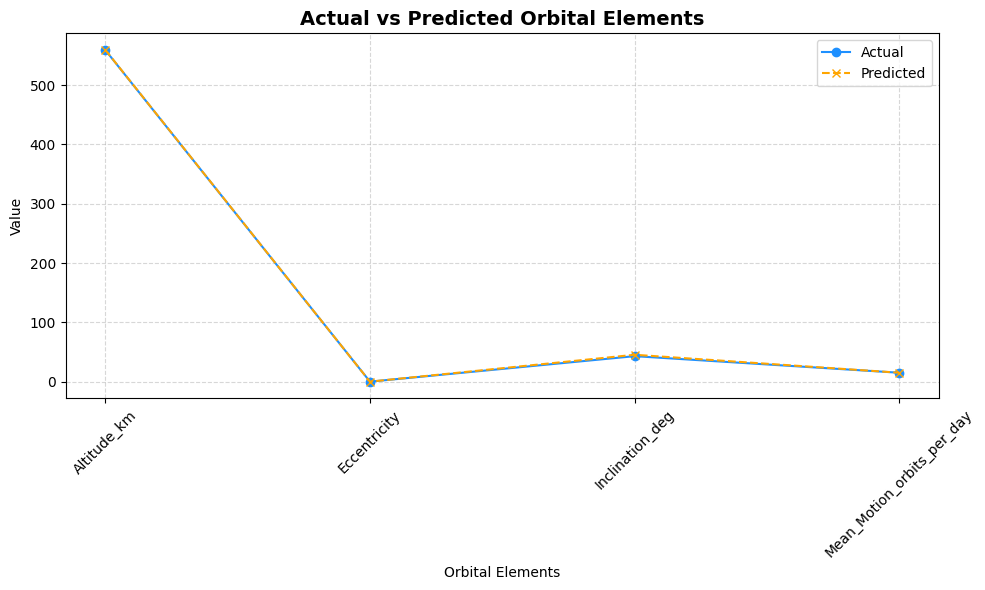

In [13]:
# Plot Actual vs Predicted
x = np.arange(len(features))
plt.figure(figsize=(10, 6))
plt.plot(x, actual, marker='o', linestyle='-', color='dodgerblue', label='Actual')
plt.plot(x, pred, marker='x', linestyle='--', color='orange', label='Predicted')
plt.title("Actual vs Predicted Orbital Elements", fontsize=14, weight='bold')
plt.xlabel("Orbital Elements")
plt.ylabel("Value")
plt.xticks(ticks=x, labels=features, rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Interactive plots

In [18]:
trace1 = go.Scatter(x=features, y=actual, mode='lines+markers', name='Actual')
trace2 = go.Scatter(x=features, y=pred, mode='lines+markers', name='Predicted')
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(title='Actual vs Predicted (Interactive)',
                  xaxis_title='Orbital Features', yaxis_title='Value')
fig.show()

Regression factors

In [14]:
# Evaluate on all samples
y_pred_scaled = model.predict(X)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 6.2012
MSE: 424.7266
R² Score: 0.4859


Trainingv vs Validation

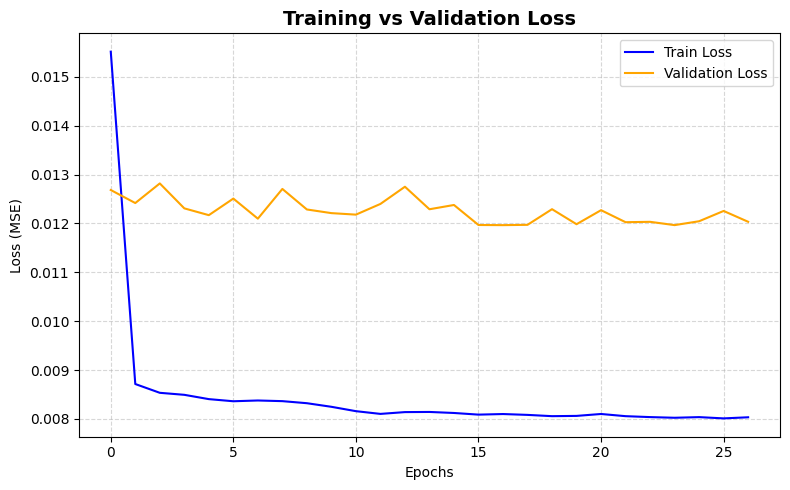

In [15]:
# === Plot Training vs Validation Loss ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss", fontsize=14, weight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Forecast data

In [ ]:
def forecast(model, last_seq, steps=5):
    forecasted = []
    seq = last_seq.copy()
    for _ in range(steps):
        pred = model.predict(seq.reshape(1, seq.shape[0], seq.shape[1]))
        forecasted.append(pred[0])
        seq = np.vstack([seq[1:], pred])
    return scaler.inverse_transform(forecasted)

last_seq = X[-1]
future_preds = forecast(model, last_seq, steps=5)

Plot forecast data

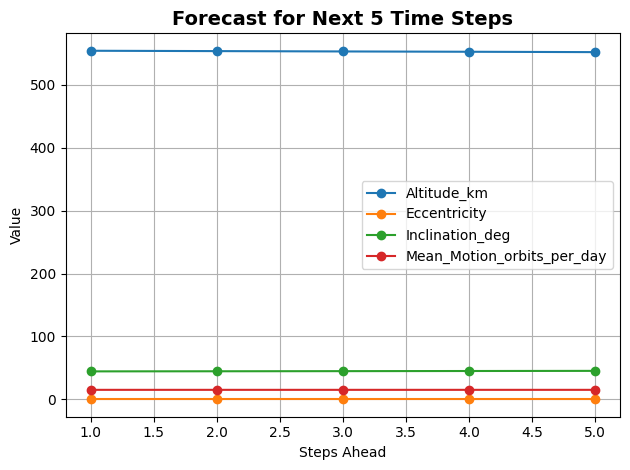

In [17]:
for i, feature in enumerate(features):
    plt.plot(range(1, 6), future_preds[:, i], marker='o', label=feature)
plt.title("Forecast for Next 5 Time Steps", fontsize=14, weight='bold')
plt.xlabel("Steps Ahead")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()